In [49]:
import mne
from mne.preprocessing import ICA
import mne_icalabel
import pandas as pd
import numpy as np
import math

#### Loading the data, removing unused channels and plotting raw data

In [50]:
# Load the .edf file
raw = mne.io.read_raw_edf('20230707152644_flanker_post_stim_p02_EEG after flanker.edf', preload=True)

# Convert annotations to events
events, event_id = mne.events_from_annotations(raw)

Extracting EDF parameters from d:\Flanker Analysis\Naveen_P02\EEG Data\20230707152644_flanker_post_stim_p02_EEG after flanker.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 336999  =      0.000 ...   673.998 secs...
Used Annotations descriptions: ['Trigger#100', 'Trigger#101', 'Trigger#102', 'Trigger#103', 'Trigger#104', 'Trigger#107']


In [51]:
raw.drop_channels(['X', 'Y', 'Z']) #Dropping accelerometer data

<RawEDF | 20230707152644_flanker_post_stim_p02_EEG after flanker.edf, 32 x 337000 (674.0 s), ~82.3 MB, data loaded>

In [52]:
all_channels = raw.ch_names #Storing all channel names
picks=['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'Cz', 'C3', 'C4'] #Picking the channels that contain useful EEG Data
bad_channels = [x for x in all_channels if not x in picks or picks.remove(x)] #Separating used channels (goods) and unused channels (bads)
raw.info['bads'].extend(bad_channels) #Removing bad channels
raw.info #Checking the good and the bad channels

<Info | 8 non-empty values
 bads: 16 items (P8, T8, CP6, P4, CP2, PO3, O1, Oz, O2, PO4, Pz, CP1, ...)
 ch_names: P8, T8, CP6, FC6, F8, F4, C4, P4, AF4, Fp2, Fp1, AF3, Fz, FC2, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: 2023-07-07 15:26:44 UTC
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>

In [53]:
raw.plot() #PLotting the raw EEG data

#### Filtering the raw data and plotting it

In [54]:
#Filtering the data using an order 50 Butterworth Filter between 1Hz and 30Hz
picks=['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'Cz', 'C3', 'C4'] #Picking the channels to filter (for speed purpose)
iir_params = dict(order=50, ftype='butter') #Setting up the Butterworth Parameters
raw.filter(1, 30, picks, method='iir', iir_params=iir_params) #Filtering the data
raw.plot()

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 200 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB



C:\Users\theri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\signal\_filter_design.py:1746: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  warnings.warn("Badly conditioned filter coefficients (numerator): the "


#### Setting the montage for the EEG Cap

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


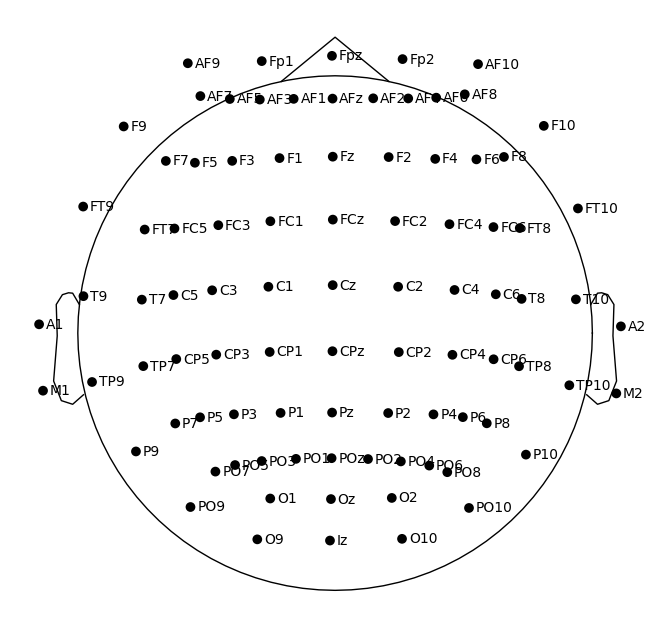

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


<RawEDF | 20230707152644_flanker_post_stim_p02_EEG after flanker.edf, 32 x 337000 (674.0 s), ~82.3 MB, data loaded>

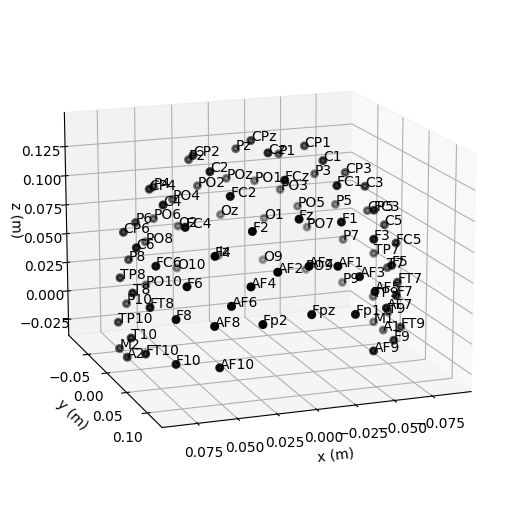

In [55]:
montage = mne.channels.make_standard_montage(kind='standard_1020', head_size='auto') #Picking up the montage that was used

#Visualising the montage
montage.plot()  # 2D
fig = montage.plot(kind="3d", show=False)  # 3D
fig = fig.gca().view_init(azim=70, elev=15)  # setting view angle

raw.set_montage(montage, on_missing='ignore', match_case=False, match_alias=True) #Setting up the montage for further preprocessing

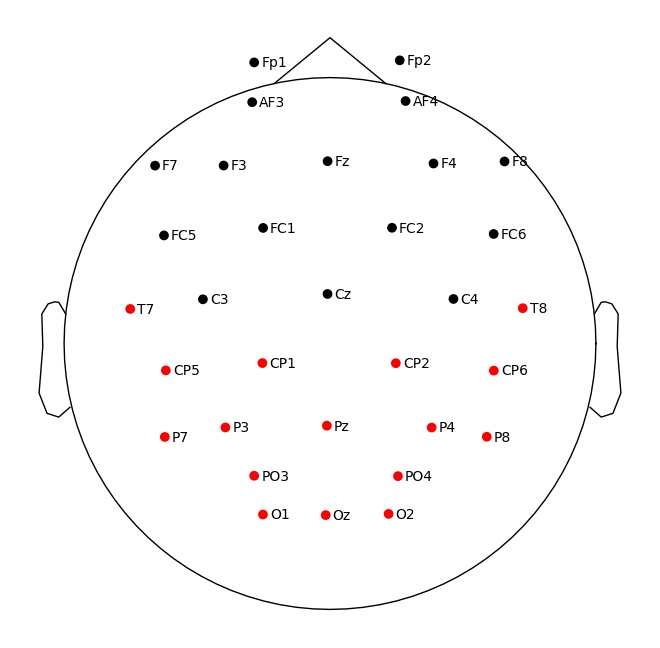

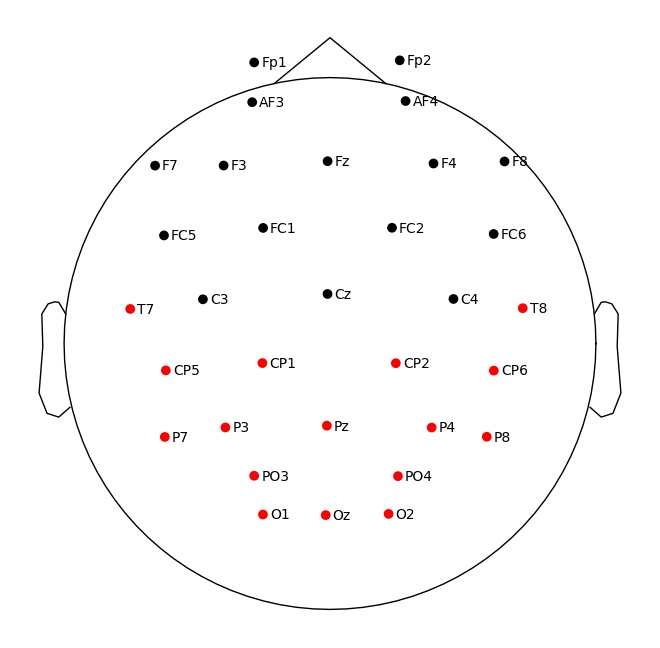

In [56]:
raw.plot_sensors(show_names=True) #PLotting the sensors that were used to collect the EEG data (shown in black)

#### Downsampling the data

In [57]:
raw.filter(1, 30)
raw_downsampled = raw.copy().resample(sfreq=500) #Downsampling the raw data from 500Hz to 250Hz
raw_downsampled.info

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Info | 9 non-empty values
 bads: 16 items (P8, T8, CP6, P4, CP2, PO3, O1, Oz, O2, PO4, Pz, CP1, ...)
 ch_names: P8, T8, CP6, FC6, F8, F4, C4, P4, AF4, Fp2, Fp1, AF3, Fz, FC2, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 1.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2023-07-07 15:26:44 UTC
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>

Effective window size : 4.096 (s)


C:\Users\theri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


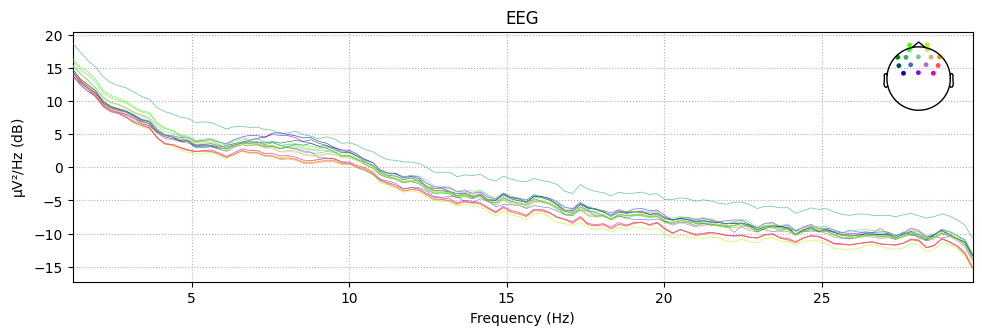

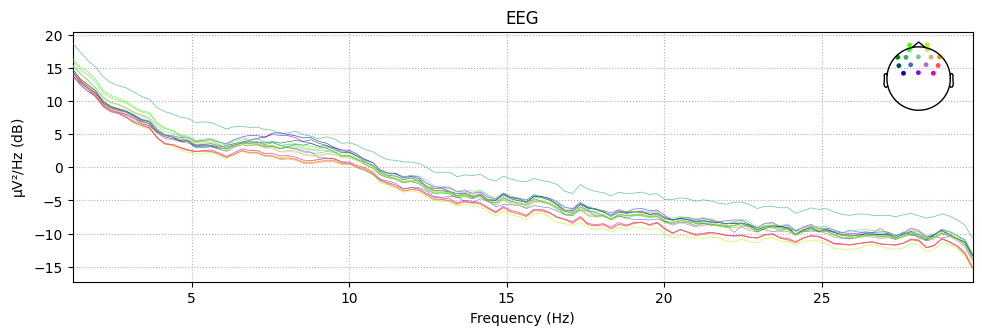

In [58]:
raw_downsampled.compute_psd(fmin=1, fmax=30).plot(picks='data', exclude='bads') #Plotting the Power Spectral Density of the downsampled data

#### Independent Component Analysis (ICA)

In [59]:
ica = ICA(n_components=15, max_iter="auto", method='picard', random_state=97) #Setting the number of components to be number of EEG channels - 1
ica.fit(raw_downsampled) #Fitting the downsampled data to the ICA
ica

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 11.9s.


<ICA | raw data decomposition, method: picard (fit in 58 iterations on 337000 samples), 15 ICA components (16 PCA components available), channel types: eeg, no sources marked for exclusion>

In [60]:
ica.plot_sources(raw_downsampled, show_scrollbars=False) #Plotting the ICA sources

Creating RawArray with float64 data, n_channels=15, n_times=337000
    Range : 0 ... 336999 =      0.000 ...   673.998 secs
Ready.


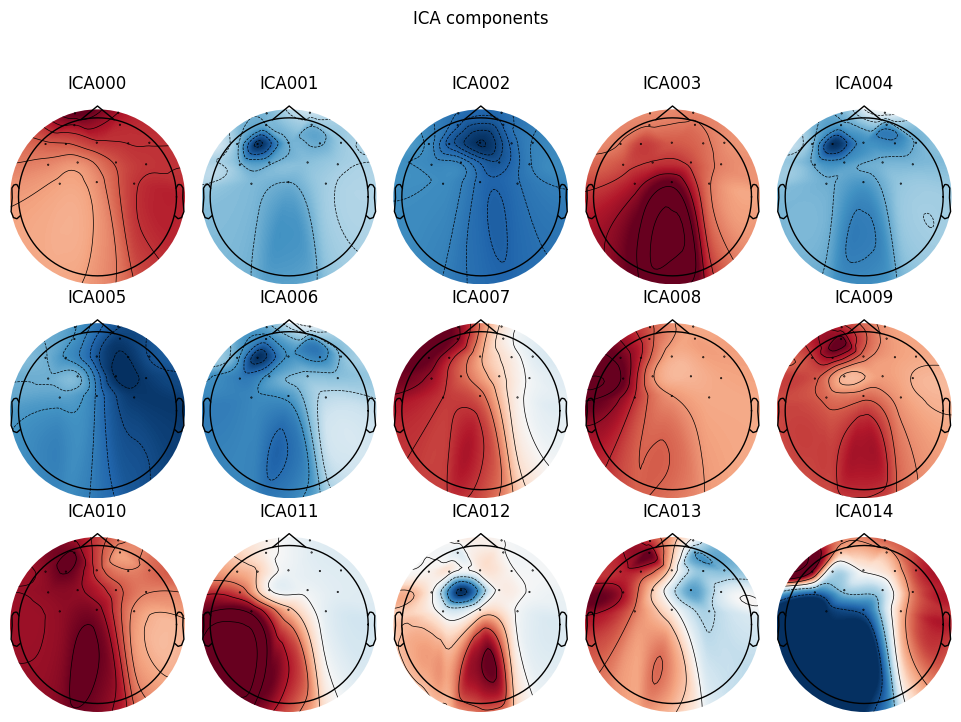

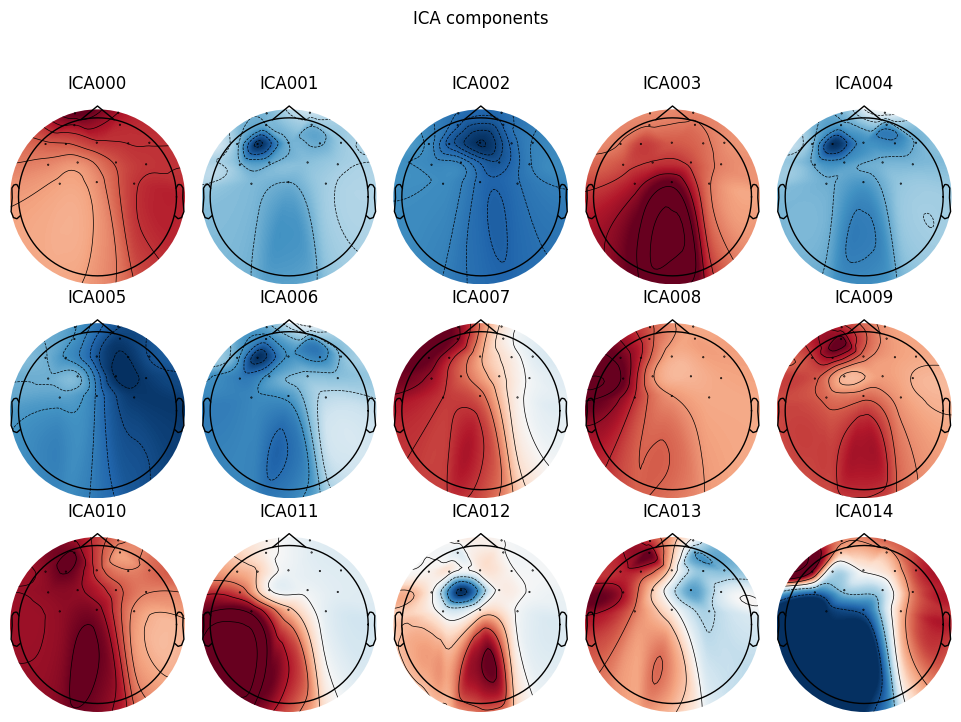

In [61]:
ica.plot_components() #PLotting the ICA components

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
337 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
337 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
337 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
337 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
337 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
337 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
337 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
337 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
337 matching events found
No baseline correction applied
0 pro

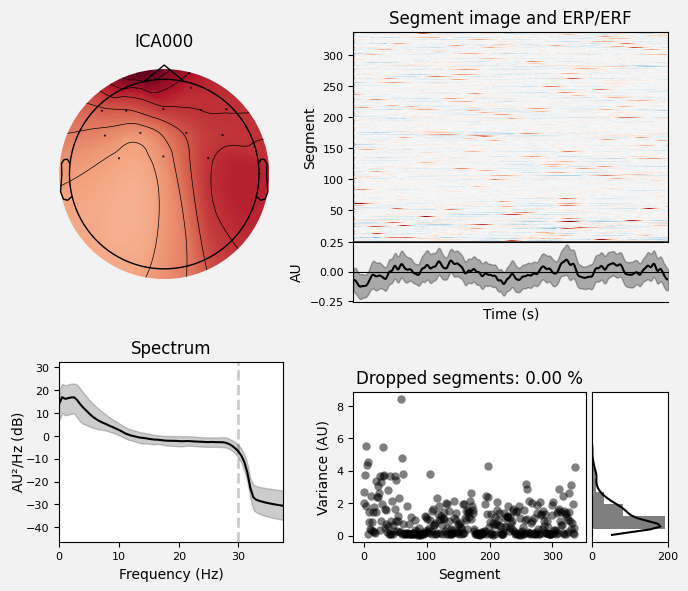

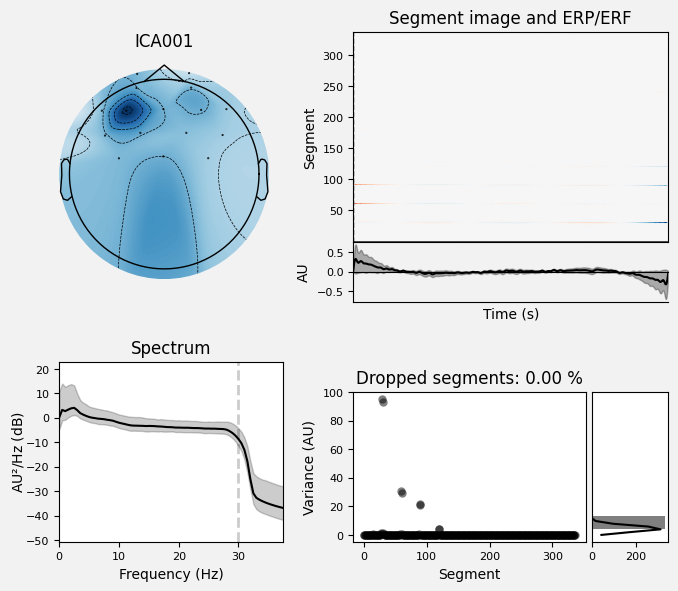

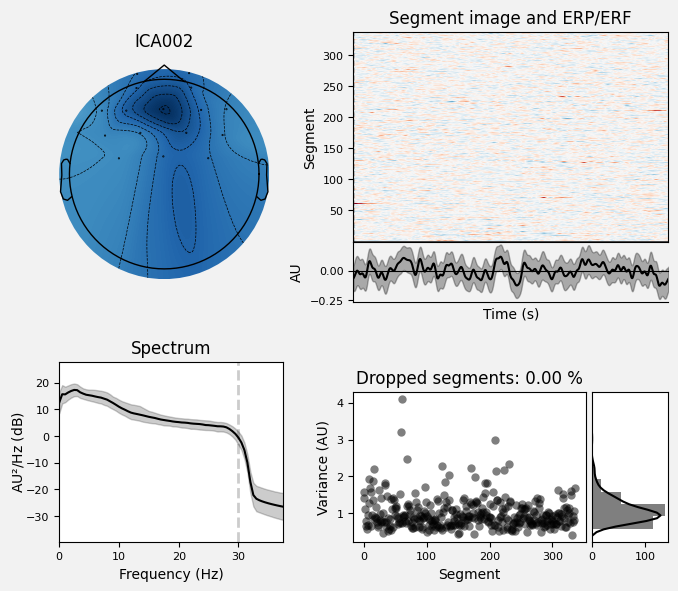

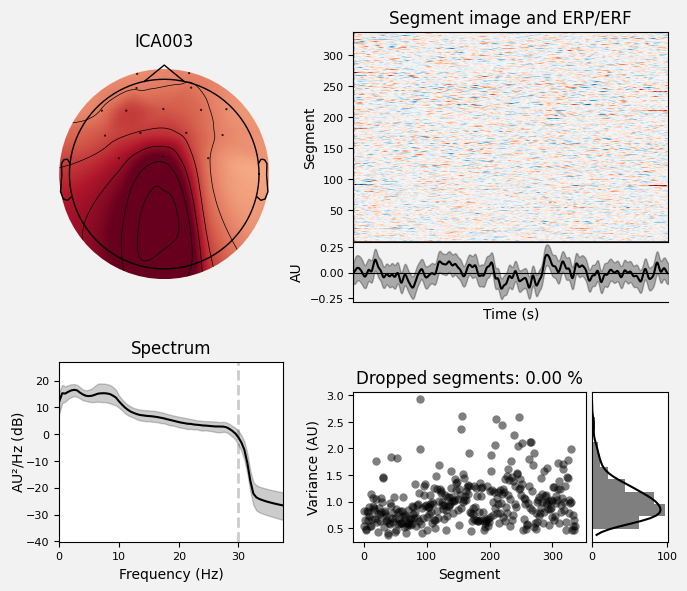

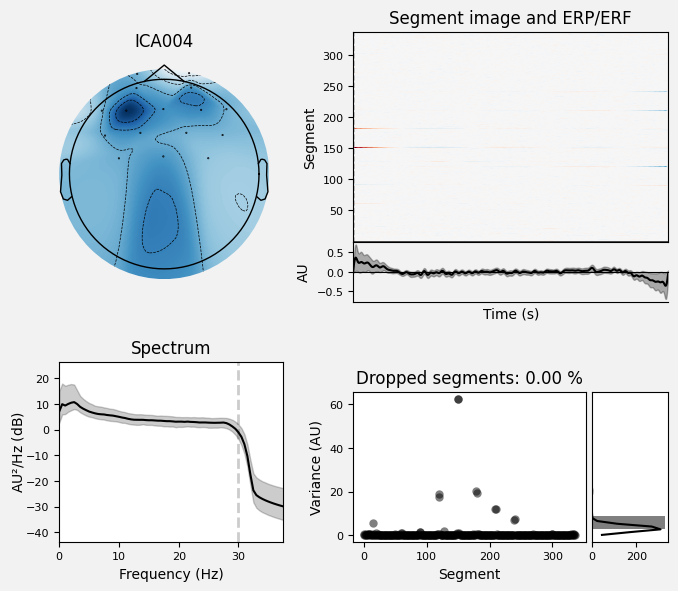

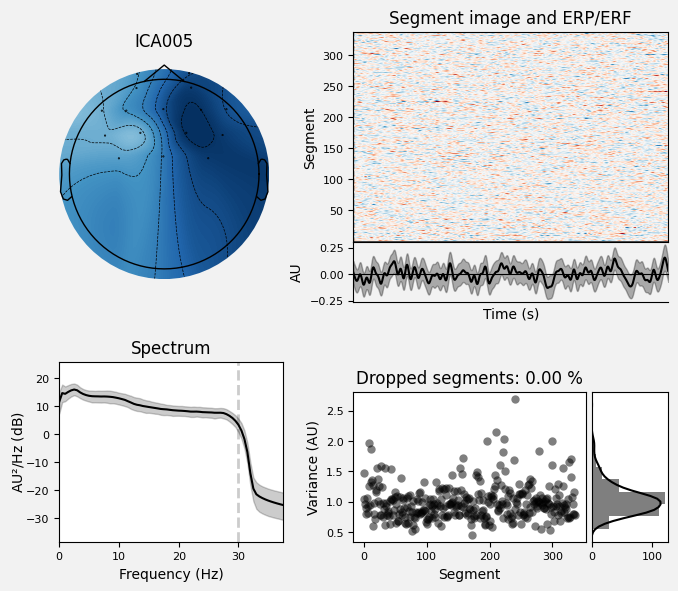

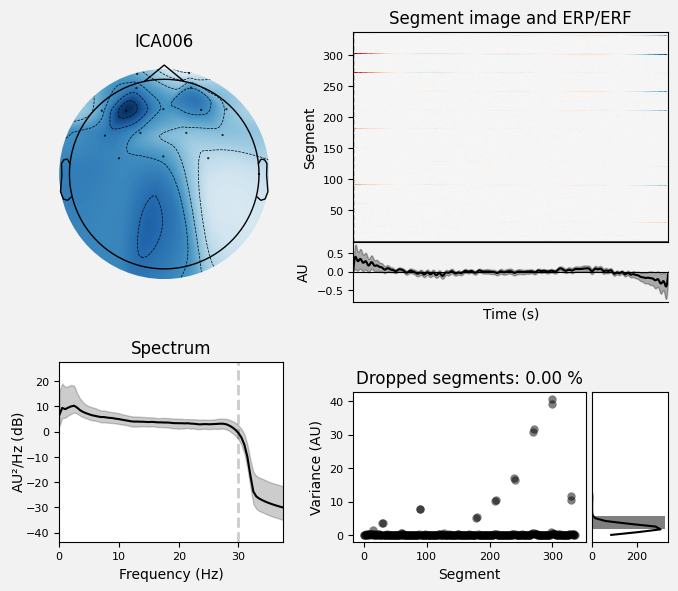

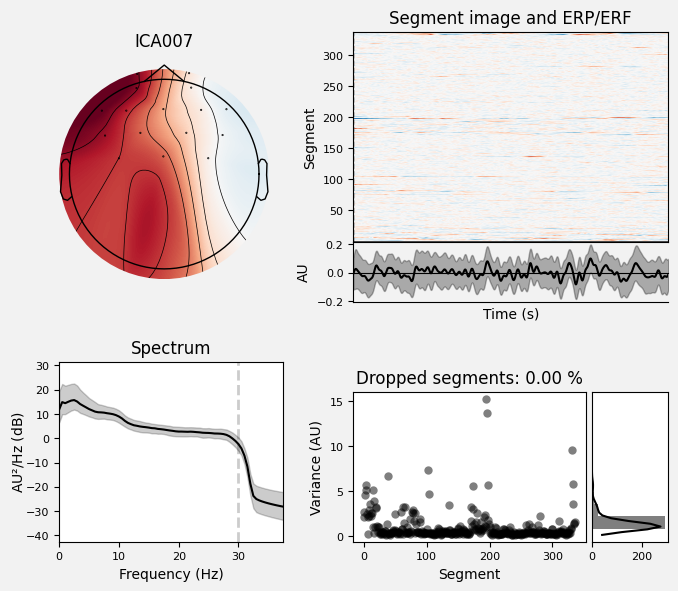

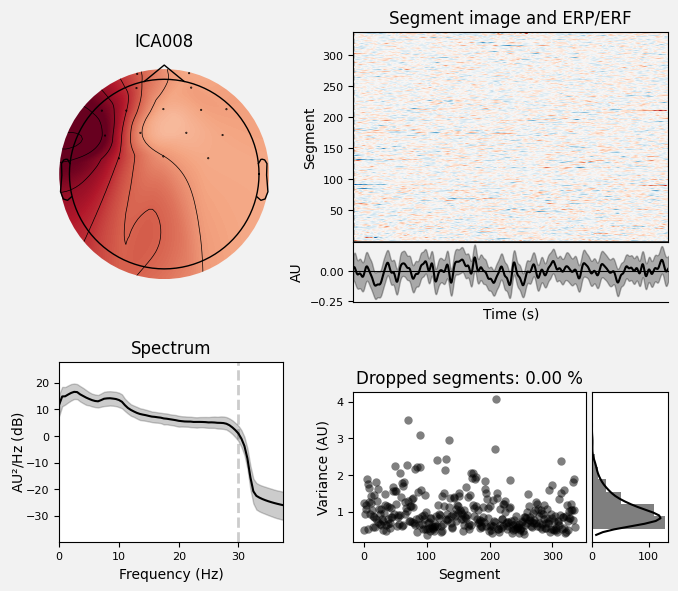

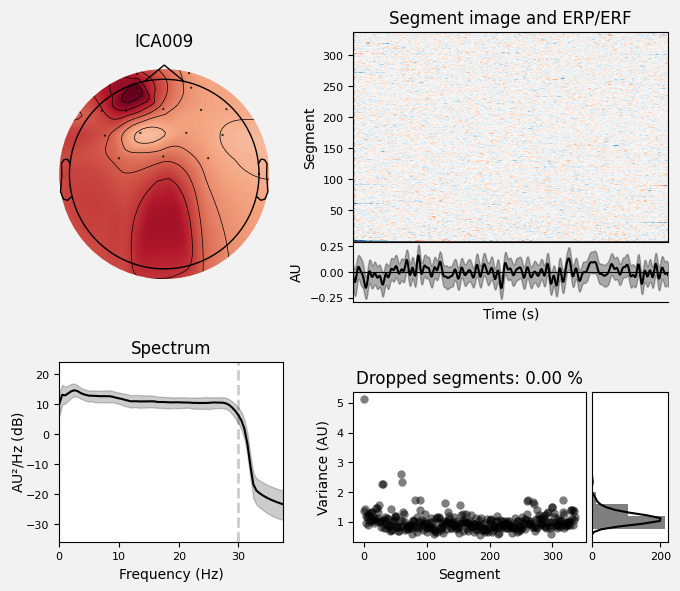

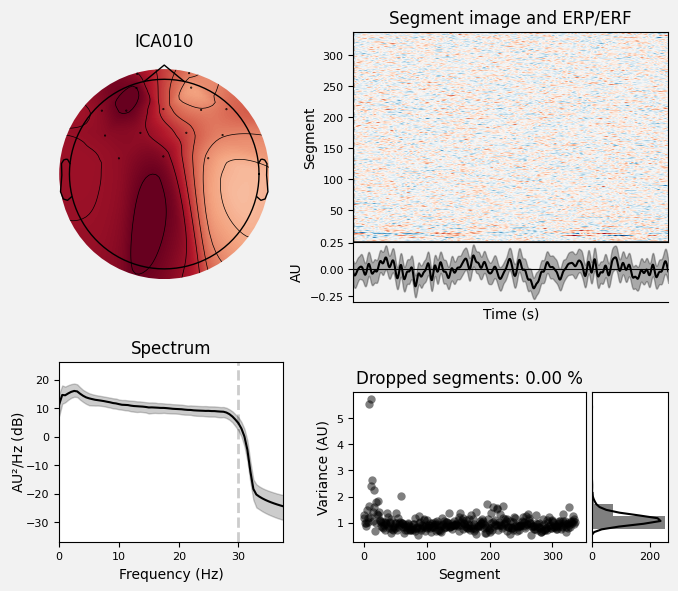

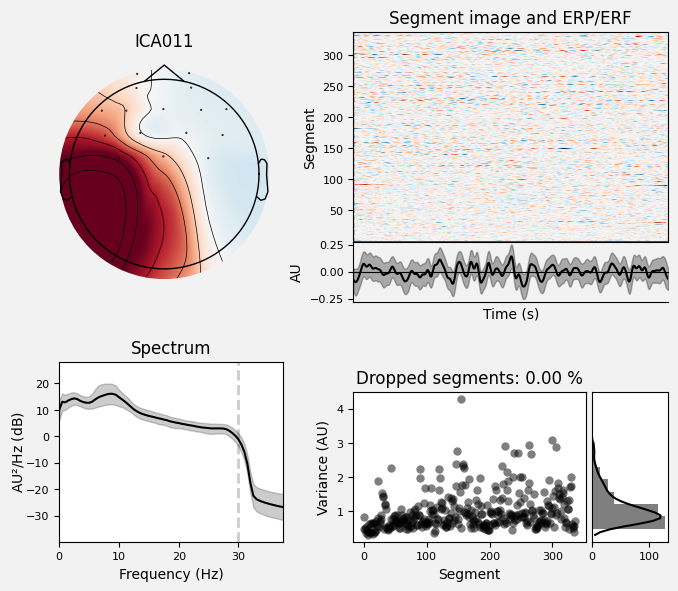

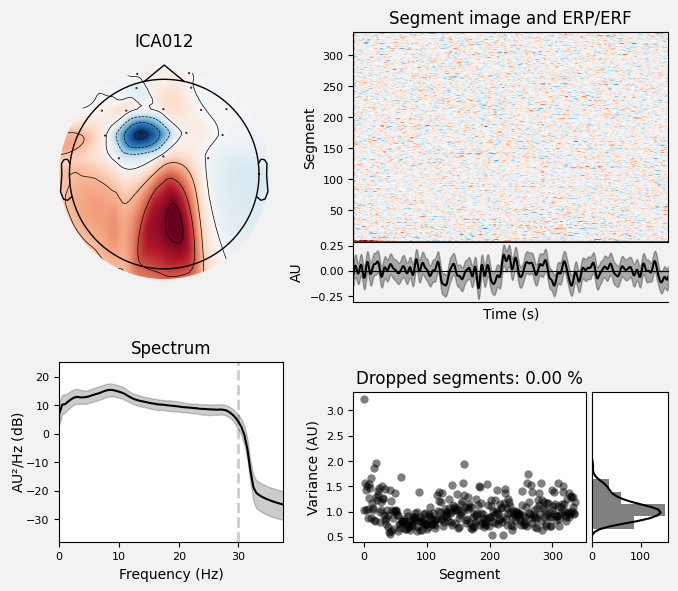

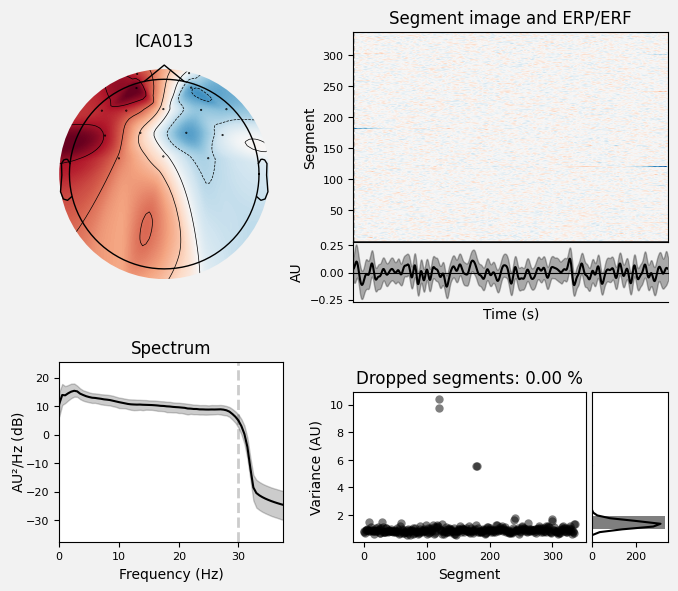

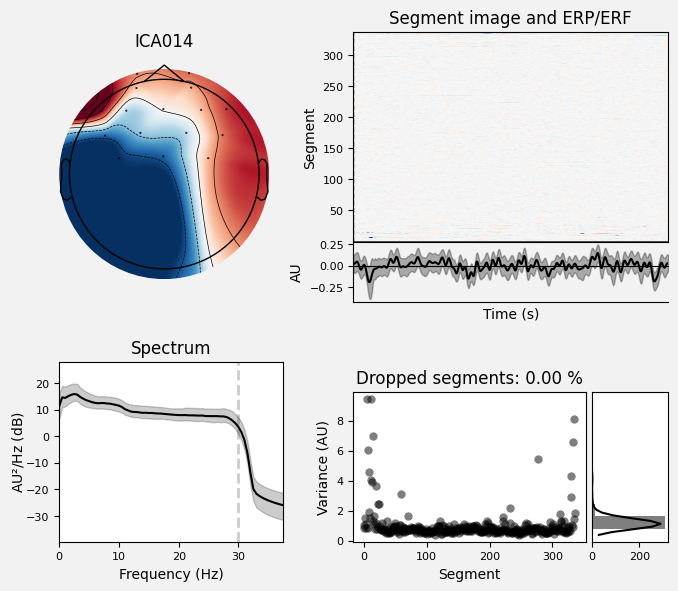

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [62]:
ica.plot_properties(raw_downsampled,  picks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], verbose=True) #Plotting each ICA property

In [63]:
# Generate the features for ICLabel neural network.
params = mne_icalabel.iclabel.get_iclabel_features(raw_downsampled, ica)

# Run the ICLabel network on the provided set of features.
labels = mne_icalabel.iclabel.run_iclabel(params[0], params[1], params[2])
# Returns the predicted numerical probability values for all labels in ICLabel output. Columns are ordered with ‘Brain’, ‘Muscle’, ‘Eye’, ‘Heart’, ‘Line Noise’, ‘Channel Noise’, and ‘Other’.

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\theri\AppData\Local\Temp\ipykernel_20744\3824795039.py:2: RuntimeWarning: The provided Raw instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  params = mne_icalabel.iclabel.get_iclabel_features(raw_downsampled, ica)
C:\Users\theri\AppData\Local\Temp\ipykernel_20744\3824795039.py:2: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  params = mne_icalabel.iclabel.get_iclabel_features(raw_downsampled, ica)
C:\Users\theri\AppData\Local\Temp\ipykernel_20744\3824795039.py:2: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA de

In [64]:
# Creating a DataFrame to store the contribution of brain, muscles, eyes, heart, line noise, channel noise and others in the individual ICA components

ica_components_data = pd.DataFrame(columns=['Brain', 'Muscle', 'Eye', 'Heart', 'Line Noise', 'Channel Noise', 'Other'])
lst = []
for i in range(len(labels)):
    lst.append({'Brain': labels[i][0] * 100, 'Muscle': labels[i][1] * 100, 'Eye': labels[i][2] * 100, 'Heart': labels[i][3] * 100, 'Line Noise': labels[i][4] * 100, 'Channel Noise': labels[i][5] * 100, 'Other': labels[i][6] * 100})
df_extended = pd.DataFrame(lst, columns=['Brain', 'Muscle', 'Eye', 'Heart', 'Line Noise', 'Channel Noise', 'Other'])
ica_components_data = pd.concat([ica_components_data, df_extended])
ica_components_data

Brain    Muscle        Eye      Heart  Line Noise  Channel Noise   
0    2.050996  0.841775  11.880516  63.169414    0.288153       0.505564  \
1   59.532225  2.820824   1.346822   2.055823    0.559532       1.250484   
2    4.669241  1.019191   0.942331  72.715330    0.554031       0.288191   
3   43.585521  1.814145   0.380132  31.633919    0.140779       0.103415   
4   71.228302  1.429829   1.305950   2.101143    0.266470       0.458224   
5    8.131029  1.193888   0.381199  79.564142    0.078762       0.081505   
6   58.047789  1.512978   4.877137   4.129184    1.378295       1.414206   
7   28.388405  1.793537   8.903085   7.678080    1.231436       1.536815   
8   76.093531  0.522265   0.143858   9.416219    0.425567       0.093343   
9    7.806323  2.213612   3.011586  50.895125    0.109814       0.121723   
10   3.286829  1.056255   0.730118  82.063901    0.178233       0.256317   
11  98.557842  0.015556   0.021877   0.673826    0.034290       0.001546   
12  90.546489  0.173110   0.094255   1.277558    0.059622       0.013130   
13  92.720050  0.264416   2.290125   0.166949    0.052280       0.063510   
14  96.753085  0.098168   0.048925   0.378054    0.694605       0.065621   

        Other  
0   21.263583  
1   32.434285  
2   19.811684  
3   22.342089  
4   23.210083  
5   10.569474  
6   28.640416  
7   50.468642  
8   13.305217  
9   35.841820  
10  12.428346  
11   0.695066  
12   7.835840  
13   4.442664  
14   1.961550

#### Excluding Components

In [65]:
#Based on the table above, excluding the following components
ica.exclude = [0, 2, 5, 9, 10]

# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw_downsampled.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 5 ICA components
    Projecting back using 16 PCA components


<RawEDF | 20230707152644_flanker_post_stim_p02_EEG after flanker.edf, 32 x 337000 (674.0 s), ~82.3 MB, data loaded>

Effective window size : 4.096 (s)


C:\Users\theri\AppData\Local\Temp\ipykernel_20744\1872595129.py:2: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  reconst_raw.compute_psd(fmin=1, fmax=30).plot()
C:\Users\theri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


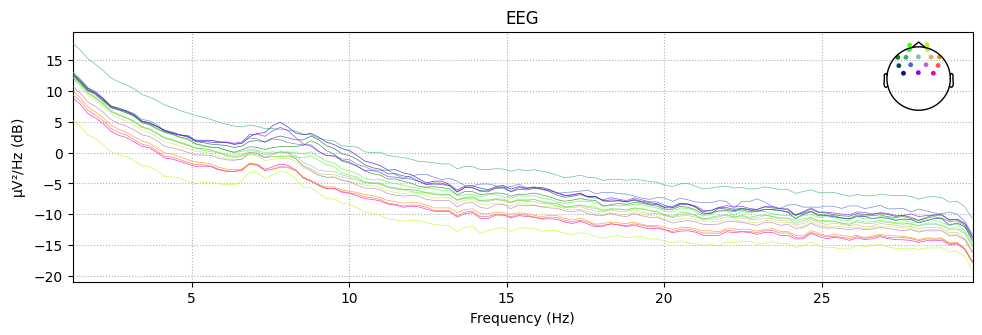

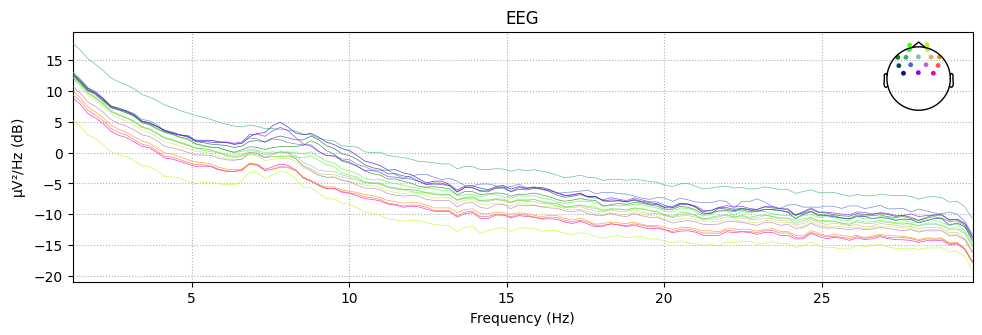

In [66]:
# Plotting the Power Spectral Density of the data post-ICA
reconst_raw.compute_psd(fmin=1, fmax=30).plot()

#### Response-Centered Epoching

In [67]:
#Checking the events
event_id

{'Trigger#100': 1,
 'Trigger#101': 2,
 'Trigger#102': 3,
 'Trigger#103': 4,
 'Trigger#104': 5,
 'Trigger#107': 6}

In [68]:
# Epoching based on the responses (correct, wrong and missing)
#In the arguments given below, set preload=False, otherwise, it will drop some of the epochs (Don't know why)
response_epochs = mne.Epochs(reconst_raw, events, [4, 5, 6], tmin=-0.5, tmax=0.8, baseline=(None, None), picks=None, preload=False, reject=None, flat=None, on_missing='ignore', reject_by_annotation=False, metadata=None, event_repeated='ignore', verbose=None)
#fig = epochs.plot(events=events) #PLotting the eopchs

Not setting metadata
214 matching events found
Setting baseline interval to [-0.5, 0.8] s
Applying baseline correction (mode: mean)
0 projection items activated


#### Analysing the epochs

In [69]:
#Computing the average of each event (response) and storing it in a list
response_epochs_average = response_epochs.average(by_event_type=True)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<Evoked | '4' (average, N=201), -0.5 – 0.8 s, baseline -0.5 – 0.8 s, 32 ch, ~205 kB>
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


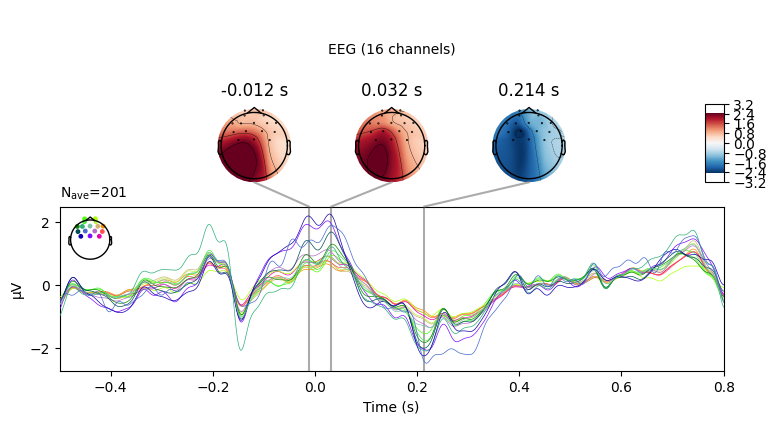

<Evoked | '5' (average, N=10), -0.5 – 0.8 s, baseline -0.5 – 0.8 s, 32 ch, ~205 kB>
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


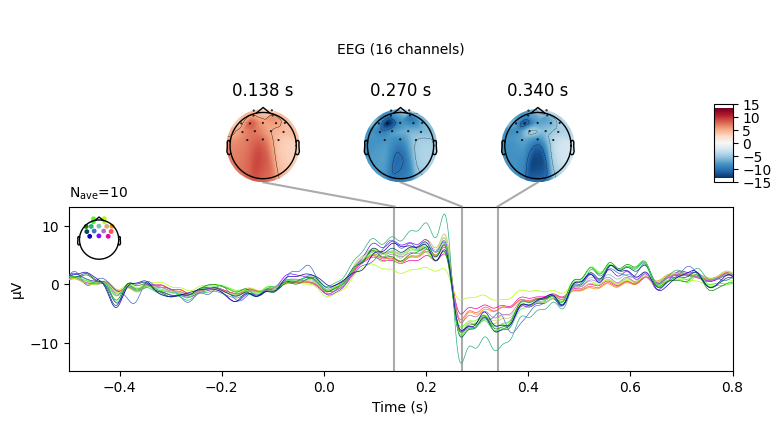

<Evoked | '6' (average, N=3), -0.5 – 0.8 s, baseline -0.5 – 0.8 s, 32 ch, ~205 kB>
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


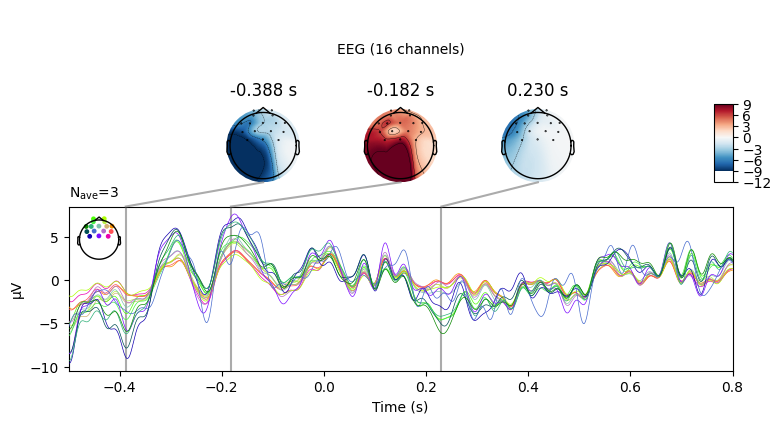

In [70]:
for i in range(3): #Plotting the ERP average for all events
    evk = response_epochs_average[i]
    print(evk)
    evk.plot_joint()

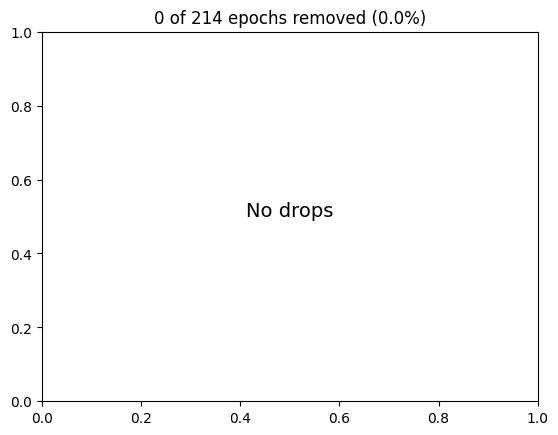

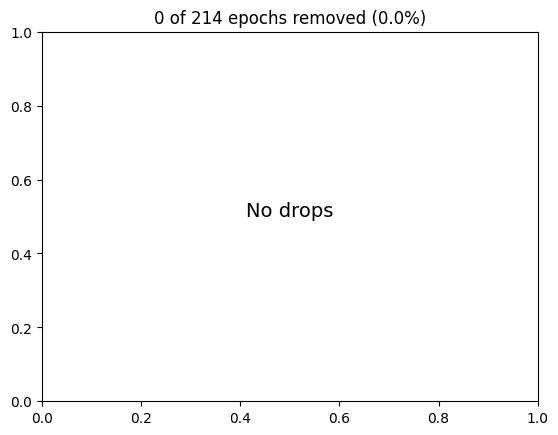

In [71]:
response_epochs.drop_bad() # Dropping any bad epochs
response_epochs.plot_drop_log() #Checking if any epochs were dropped or not

#### Analyzing the Events

In [72]:
# Storikng the events in separate epochs for further separation
correct_epochs = response_epochs['4']
wrong_epochs = response_epochs['5']
missing_epochs = response_epochs['6']

In [73]:
# Checking the event epochs and average epochs datatype (for correct only)
print(type(correct_epochs))
print(type(response_epochs_average[0]))

<class 'mne.epochs.Epochs'>
<class 'mne.evoked.EvokedArray'>


##### Loading and separating the behavioural data

In [74]:
behavioural_data = pd.read_csv('poststim.csv') #Loading the post-stimulation behavioural data

In [75]:
correct_trials = behavioural_data[behavioural_data['key_resp.corr'] == 1] #Separating the correct trials

In [76]:
wrong_missing = behavioural_data[behavioural_data['key_resp.corr'] == 0]

In [77]:
missing_trials = wrong_missing[(wrong_missing['key_resp.keys'] != 'right') & (wrong_missing['key_resp.keys'] != 'left')] #Separating missing trials

In [78]:
wrong_trials = wrong_missing[(wrong_missing['key_resp.keys'] == 'right') | (wrong_missing['key_resp.keys'] == 'left')] #Separating wrong trials

In [79]:
# Taking the indices of correct congruent and incongruent trials
correct_congruent_indices = []
correct_incongruent_indices = []
congruent_correct = (correct_trials['congruent']).to_numpy()

for i in range(len(congruent_correct)):
    if congruent_correct[i] == 0:
        correct_incongruent_indices.append(i)
    else:
        correct_congruent_indices.append(i)

In [80]:
# Taking the indices of wrong congruent and incongruent trials
wrong_congruent_indices = []
wrong_incongruent_indices = []
congruent_wrong = (wrong_trials['congruent']).to_numpy()
for i in range(len(congruent_wrong)):
    if congruent_wrong[i] == 0:
        wrong_incongruent_indices.append(i)
    else:
        wrong_congruent_indices.append(i)

In [81]:
# Taking the indices of missing congruent and incongruent trials
missing_congruent_indices = []
missing_incongruent_indices = []
congruent_missing = (missing_trials['congruent']).to_numpy()
for i in range(len(congruent_missing)):
    if congruent_missing[i] == 0:
        missing_incongruent_indices.append(i)
    else:
        missing_congruent_indices.append(i)

##### Separating the ERPs based on congruency and result

In [82]:
congruent_correct_epochs = correct_epochs[correct_congruent_indices]
congruent_wrong_epochs = wrong_epochs[wrong_congruent_indices]
congruent_missing_epochs = missing_epochs[missing_congruent_indices]

In [83]:
incongruent_correct_epochs = correct_epochs[correct_incongruent_indices]
poststim_incongruent_wrong_epochs = wrong_epochs[wrong_incongruent_indices]
incongruent_missing_epochs = missing_epochs[missing_incongruent_indices]

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


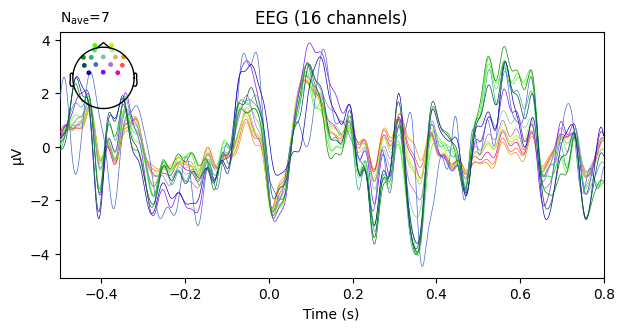

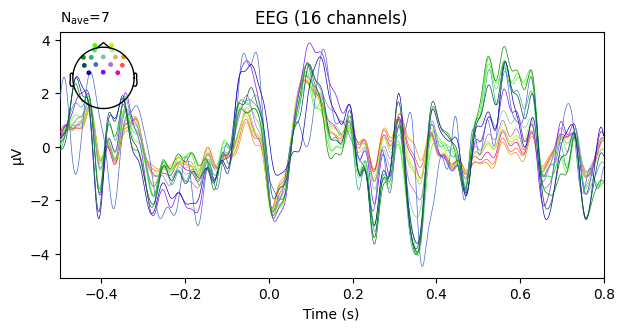

In [84]:
poststim_incongruent_wrong_epochs.average().plot()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


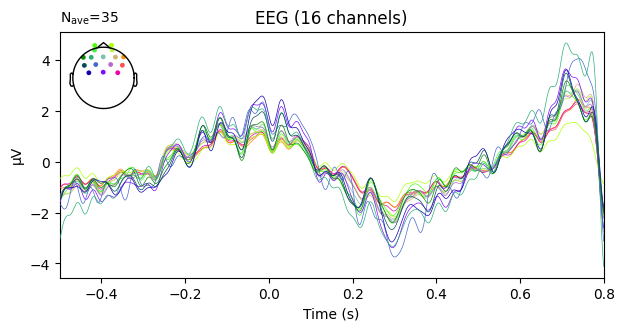

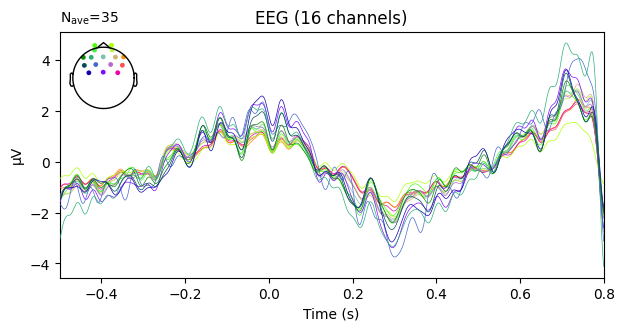

In [85]:
incongruent_correct_epochs.average().plot()

In [86]:
n200 = poststim_incongruent_wrong_epochs.average().get_data(picks = picks,tmin = 0.160, tmax = 250)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [87]:
p300 = poststim_incongruent_wrong_epochs.average().get_data(picks = picks, tmin = 0.250, tmax = 0.460)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [88]:
#Looking at n200 peaks at various channels
n200_ch = []
for i in range(len(picks)):
    n200_ch.append(n200[i].min())
    print(picks[i], "n200:", n200_ch[i])

Fp1 n200: -3.962192604158275e-06
Fp2 n200: -1.258338685674661e-06
AF3 n200: -4.068963440318276e-06
AF4 n200: -1.2562083422479072e-06
F7 n200: -4.031389110728493e-06
F3 n200: -4.0088070111121164e-06
Fz n200: -2.6362432895231924e-06
F4 n200: -1.3949319206339825e-06
F8 n200: -1.1026034095303866e-06
FC5 n200: -3.811256119191358e-06
FC1 n200: -4.4678025142409015e-06
FC2 n200: -1.98694116741162e-06
FC6 n200: -9.63837838240433e-07
Cz n200: -3.928343677162365e-06
C3 n200: -3.6027319926833348e-06
C4 n200: -1.17073365062006e-06


In [89]:
#Looking at p300 peaks at various channels
p300_ch = []
for i in range(len(picks)):
    p300_ch.append(p300[i].max())
    print(picks[i], "p300:", p300_ch[i])

Fp1 p300: 5.919949997192274e-07
Fp2 p300: 1.0118520624531132e-06
AF3 p300: 2.1875927878844427e-07
AF4 p300: 9.809751796472393e-07
F7 p300: 1.49662660891152e-06
F3 p300: 9.629746110303075e-07
Fz p300: 4.5513755604181295e-07
F4 p300: 7.748205445564165e-07
F8 p300: 1.2323334983448017e-06
FC5 p300: 1.695274086673551e-06
FC1 p300: 1.2908540632533132e-06
FC2 p300: 7.629817440313605e-07
FC6 p300: 1.2369171952942749e-06
Cz p300: 1.1063120476602294e-06
C3 p300: 1.9939284229905814e-06
C4 p300: 1.0268027313771064e-06


In [90]:
# Creating a table of peak data
peak_data = pd.DataFrame(columns=['Channels', 'N200', 'P300'])
lst = []
for i in range(len(picks)):
    lst.append({'Channels': picks[i], 'N200': n200_ch[i], 'P300': p300_ch[i]})
df_extended = pd.DataFrame(lst, columns=['Channels', 'N200', 'P300'])
peak_data = pd.concat([peak_data, df_extended])

In [91]:
peak_data['Score'] = peak_data.iloc[:, 2] - peak_data.iloc[:, 1] # Sorting the dataframe according to the peak-to-peak distance
peak_data_sorted = peak_data.sort_values(by = 'Score', ascending = False)
peak_data_sorted

Channels          N200          P300     Score
10      FC1 -4.467803e-06  1.290854e-06  0.000006
14       C3 -3.602732e-06  1.993928e-06  0.000006
4        F7 -4.031389e-06  1.496627e-06  0.000006
9       FC5 -3.811256e-06  1.695274e-06  0.000006
13       Cz -3.928344e-06  1.106312e-06  0.000005
5        F3 -4.008807e-06  9.629746e-07  0.000005
0       Fp1 -3.962193e-06  5.919950e-07  0.000005
2       AF3 -4.068963e-06  2.187593e-07  0.000004
6        Fz -2.636243e-06  4.551376e-07  0.000003
11      FC2 -1.986941e-06  7.629817e-07  0.000003
8        F8 -1.102603e-06  1.232333e-06  0.000002
1       Fp2 -1.258339e-06  1.011852e-06  0.000002
3       AF4 -1.256208e-06  9.809752e-07  0.000002
12      FC6 -9.638378e-07  1.236917e-06  0.000002
15       C4 -1.170734e-06  1.026803e-06  0.000002
7        F4 -1.394932e-06  7.748205e-07  0.000002

In [92]:
top_picks = peak_data_sorted.head(3).to_numpy().T[0] # Extracting the top 3 electrodes with maximum peak-to-peak value

In [93]:
top_picks = top_picks.tolist()
print(top_picks)

['FC1', 'C3', 'F7']


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


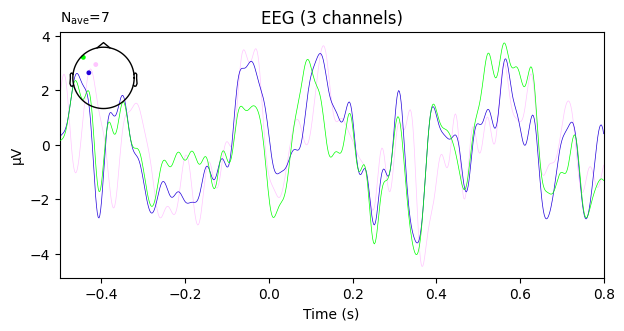

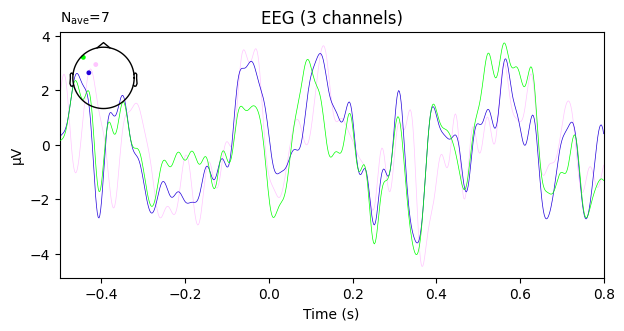

In [94]:
#Plotting the peak 3 electrodes
poststim_incongruent_wrong_epochs.average().plot(picks=top_picks)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


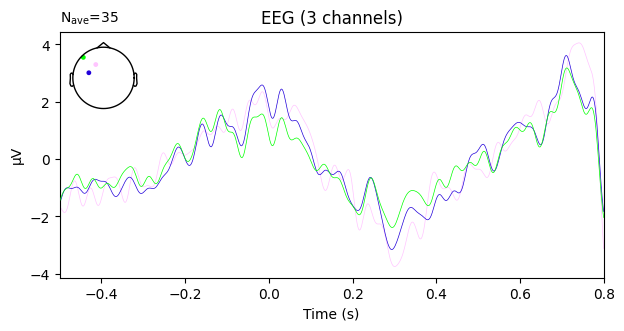

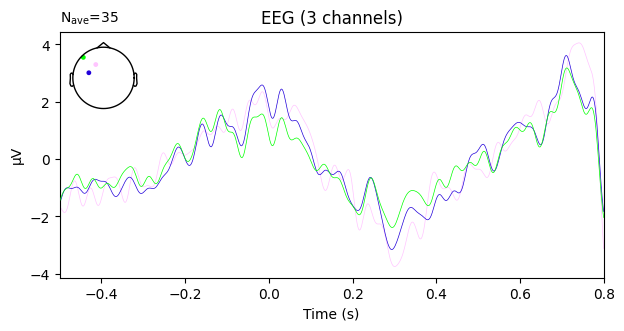

In [95]:
incongruent_correct_epochs.average().plot(picks=top_picks)

In [97]:
%store poststim_incongruent_wrong_epochs

Stored 'poststim_incongruent_wrong_epochs' (Epochs)


Channels marked as bad:
['P8', 'T8', 'CP6', 'P4', 'CP2', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'Pz', 'CP1', 'P3', 'CP5', 'T7', 'P7']
Channels marked as bad:
['P8', 'T8', 'CP6', 'P4', 'CP2', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'Pz', 'CP1', 'P3', 'CP5', 'T7', 'P7']
Channels marked as bad:
['P8', 'T8', 'CP6', 'P4', 'CP2', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'Pz', 'CP1', 'P3', 'CP5', 'T7', 'P7']
Channels marked as bad:
['P8', 'T8', 'CP6', 'P4', 'CP2', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'Pz', 'CP1', 'P3', 'CP5', 'T7', 'P7']
